### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework. 
### Radmehr Ghassabtabarshiadeh

Begin your report here...

A/B testing to determine whether SHVR or ZIC traders perform better using BSE market sessions simulation. Test the null hypothesis that there is no signifacnt difference between the two traders and the alternative hypothesis of there being a signifacnt difference between the two traders with the significance value set to 0.05. A market session will run with the specification mentioned on the brief. start time and end time are set to 0 and 600 respectively. After the simulation are complete, two data frames are created, one with everything the "dump_avgbals" creates and another only taking in the average profit of each trader at a time step. To test the hypothesis, a "T test" was used, this test allows to see whether the observed differences are statistically significant. Some helper functions are below to help do what was described. The functions "make_df" and "ttest" are helper functions for "run_market_sim" which create a dataframe and conduct t-test for each market session. the p value is then added to an array and the average of it returned.

In [1]:
# Some code...
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
from scipy import stats
import pandas as pd
import seaborn as sns 

from BSE import market_session

def make_df(path: str):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2', 'err']
    df_profit = df[['avg profit1', 'avg profit2']]
    df_profit.columns = ['SHVR', 'ZIC']
    return df, df_profit

def ttest(df):
    zic_avg = df['ZIC']
    shvr_avg = df['SHVR']
        
    t_statistic, p_value = stats.ttest_ind(zic_avg, shvr_avg)
    return t_statistic, p_value

def trader_specs_two(R, n):
    SHVR_num = (n*R)//100
    zic_num = ((100-R)*n)//100
    buyer_spec = [('SHVR', SHVR_num), ('ZIC', zic_num)]
    seller_spec = [('SHVR', SHVR_num), ('ZIC', zic_num)]
    trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
    return trader_specs

def run_market_sim(trial_id, no_sessions, R, n, supply_range, demand_range, start_time, end_time, path):
    trader_specs = trader_specs_two(R, n)
    p_val = []
    
    for _ in range(no_sessions):
        supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
        demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
        order_interval = 60
        order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                    'interval': order_interval, 'timemode': 'periodic'}
        dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                    'dump_avgbals': True, 'dump_tape': False}

        verbose = False
        market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
        _, df_profit = make_df(path)
        _, p_value = ttest(df_profit)
        p_val.append(p_value)
    
    return np.mean(p_val)

Seaborn library is used to visualise the data frame to determine wheteher the average profit is normaly distributed or not. As the output show, the data is somewhat normally distributed and can be passed for T-test without the need for furthur normalisation.

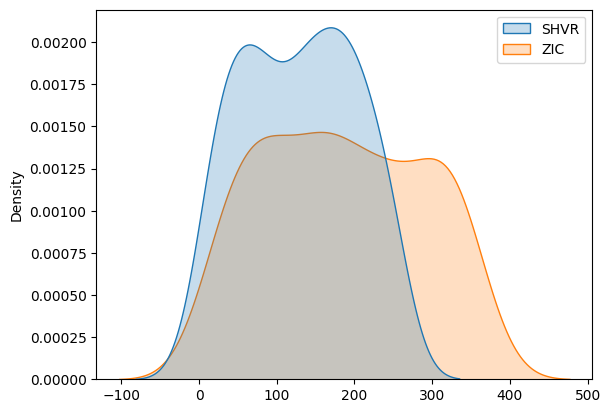

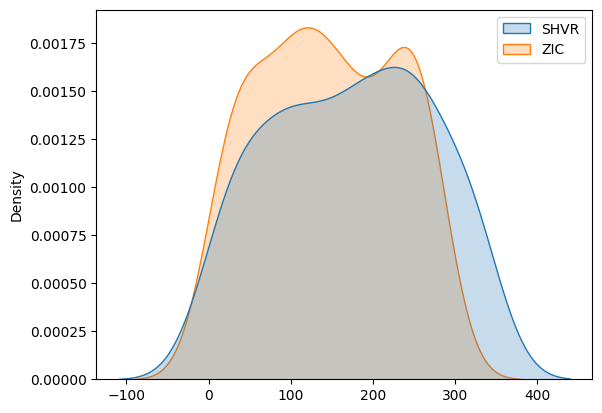

In [2]:
_, df50 = make_df('n50_avg_balance.csv')
_, df500 = make_df('n500_avg_balance.csv')
plot_500 = sns.kdeplot(data=df500, fill=True)
plt.show()
plot_50 = sns.kdeplot(data=df50, fill=True)

In [ ]:
n50P_avg = run_market_sim(trial_id="n500", no_sessions=500, R=50, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=60*10, path='n500_avg_balance.csv')
n500P_avg = run_market_sim(trial_id="n50", no_sessions=50, R=50, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=60*10, path='n50_avg_balance.csv')
print(n50P_avg, n500P_avg)

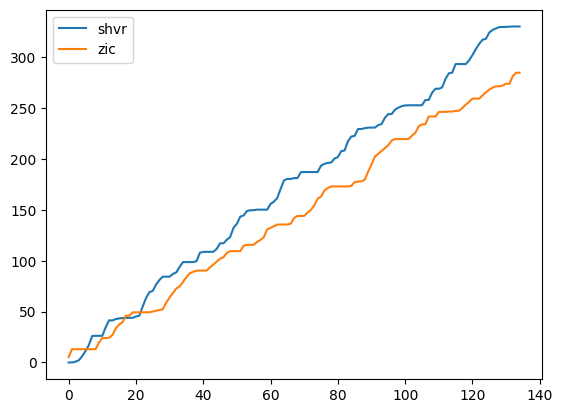

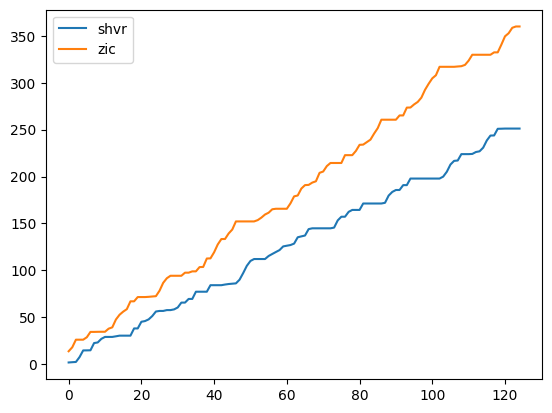

In [3]:
plt.plot(df50)
plt.legend(['shvr', 'zic'])
plt.show()
plt.plot(df500)
plt.legend(['shvr', 'zic'])

The average P-value for both market sessions are above the threshold of 0.05 suggesting that there is not enough evidence to reject the null hypothesis. The results suggest that the profablity of the two are statistically indistinguishable, however from the visualisation we observe that, shvr has higher profit on average.

in conclusion, there is not enough evidence to distinguish the two traders since they both can return a profit however, as the number of market session rises, the shvr trader performes slightly better than the ZIC trader.

In [4]:
def R_market_run(R, no_sessions, n, supply_range, demand_range, start_time, end_time):
    res = []
    tmp = "n" + str(no_sessions) + "_"
    for r in R:
        trial_id = tmp + str(r)
        path = str(trial_id) + "_avg_balance.csv"
        res.append(run_market_sim(trial_id, no_sessions, r, n, supply_range, demand_range, start_time, end_time, path))

    return res

In [ ]:
R = [10, 20, 30, 40, 50, 60, 70, 80, 90]

res50 = R_market_run(R, 50, 20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
res500 = R_market_run(R, 500, 20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

In [ ]:
print(res50)
print(res500)

In [26]:
def anova_test(df):
    shvr_avg = df['SHVR']
    gvwy_avg = df['GVWY']
    zic_avg = df['ZIC']
    zip_avg = df['ZIP']
    _, p = stats.f_oneway(shvr_avg, gvwy_avg, zic_avg, zip_avg)
    return p

def shift(t, s):
    s = s % len(t)
    return t[s:] + t[:s]

def df_four(path):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2',
                   'trader3', 'total profit3', 'no. 3', 'avg profit3', 'trader4', 'total profit4', 'no. 4', 'avg profit4', 'err']
    df_profit = df[['avg profit1', 'avg profit2', 'avg profit3', 'avg profit4']]
    df_profit.columns = ['GVWY', 'SHVR', 'ZIC', 'ZIP']
    return df, df_profit    

def four_trader_specs(t: list, n: int):
    res = []
    for i in range(len(t)):
        t = np.roll(t, i)
        tmp = []
        for x in t:
            tmp.append(int(x))
        t = tmp
        shvr_num = (t[0]*n)/100
        gvwy_num = (t[1]*n)/100
        zic_num = (t[2]*n)/100
        zip_num = (t[3]*n)/100
        buyer_specs = [('SHVR', int(shvr_num)), ('GVWY', int(gvwy_num)), ('ZIC', int(zic_num)), ('ZIP', int(zip_num))]
        seller_specs = [('SHVR', int(shvr_num)), ('GVWY', int(gvwy_num)), ('ZIC', int(zic_num)), ('ZIP', int(zip_num))]
        trader_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
        res.append(trader_specs)
    return res

def run_market_sim_four(trial_id, no_sessions, t, n, supply_range, demand_range, start_time, end_time):
    res = []

    if t == [25, 25, 25, 25]:
        seller_spec = [('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
        buyer_spec = [('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
        trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
        path = str(trial_id) + "_avg_balance.csv"
        p_val = []
        for _ in range(no_sessions):
            supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
            demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
            order_interval = 60
            order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                            'interval': order_interval, 'timemode': 'periodic'}
            dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                            'dump_avgbals': True, 'dump_tape': False}
            verbose = False
            market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
            _, df_profit = df_four(path)
            p_value = anova_test(df_profit)
            p_val.append(p_value)
        res.append(p_val)
    else:
        trader_specs = four_trader_specs(t, n)

        for i, ts in enumerate(trader_specs):
            trial_id = trial_id + str(i)
            path = str(trial_id) + "_avg_balance.csv"
            p_val = []
            for _ in range(no_sessions):
                supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
                demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
                order_interval = 60
                order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                            'interval': order_interval, 'timemode': 'periodic'}
                dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                            'dump_avgbals': True, 'dump_tape': False}
                verbose = False
                market_session(trial_id, start_time, end_time, ts, order_sched, dump_flags, verbose)
                _, df_profit = df_four(path)
                p_value = anova_test(df_profit)
                p_val.append(p_value)
            res.append(p_val)
    return np.mean(res)

In [28]:
t = [25, 25, 25, 25]
t1 = [40, 20, 20, 20]
t2 = [10, 30, 30, 30]
t3 = [70, 10, 10, 10]

r150 = run_market_sim_four("same50", no_sessions=50, t=t, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r250 = run_market_sim_four("forty50", no_sessions=50, t=t1, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r350 = run_market_sim_four("ten50", no_sessions=50, t=t2, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r450 = run_market_sim_four("seventy50", no_sessions=50, t=t3, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

r1500 = run_market_sim_four("same500", no_sessions=500, t=t, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r2500 = run_market_sim_four("forty500", no_sessions=500, t=t1, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r3500 = run_market_sim_four("ten500", no_sessions=500, t=t2, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r4500 = run_market_sim_four("seventy500", no_sessions=500, t=t3, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

In [47]:
np.mean(r1500)

0.0022613862060418865

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [ ]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

In [ ]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "CW-IEFT-template.ipynb" # Enter name of this file here
printWordCount(this_file_name)